In [2]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("OPENAI_API_VERSION")
_set_if_undefined("AZURE_OPENAI_ENDPOINT")

In [5]:
import os
import logging
from typing import Annotated, List, Literal, TypedDict, Optional

from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import (
    VectorizableTextQuery,
    QueryType,
    QueryCaptionType,
    QueryAnswerType,
)
from langchain_community.tools import tool
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_openai import AzureChatOpenAI
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent

# Load environment variables
load_dotenv()

# Global constants for Azure Cognitive Search configuration
SEARCH_SERVICE = os.getenv("AZURE_COGNITIVE_SEARCH_SERVICE_NAME")
INDEX_NAME = os.getenv("AZURE_SEARCH_INDEX_NAME")
SEARCH_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")

# Initialize clients
llm = AzureChatOpenAI(api_key=AZURE_OPENAI_API_KEY, model="gpt-4o")
search_client = SearchClient(
    endpoint=f"https://{SEARCH_SERVICE}.search.windows.net",
    index_name=INDEX_NAME,
    credential=AzureKeyCredential(SEARCH_API_KEY),
)


# Utility Functions
def get_last_human_message(messages: List[HumanMessage]) -> Optional[str]:
    """
    Retrieve the content of the last human message from a conversation.

    :param messages: List of messages in the conversation.
    :return: The content of the last HumanMessage, or None if not found.
    """
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content
    return None


# Tools
@tool
def scrape_webpages(queries: List[str]) -> str:
    """
    Perform web scraping using the DuckDuckGo search engine.

    :param queries: List of user queries to search on the web.
    :return: Aggregated results as a string.
    """
    wrapper = DuckDuckGoSearchAPIWrapper(max_results=2)
    answer = []

    for query in queries:
        search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format="list")
        results = search.invoke(query)
        answer.append("\n\n".join(
        [f'<Document name="{doc["title"]}">\n{doc["snippet"]}\n</Document>' for doc in results]
        ))

    return "\n\n".join(answer)


@tool
def search_index(search_query: str, taxonomy_filter: str) -> str:
    """
    Searches for taxonomies in the Azure Cognitive Search index based on a concept label and definition.  
  
    :param search_query: the search query of the user 
    :param taxonomy_filter: An optional filter to apply to the taxonomy search.  
    :return: The search results from the Azure Cognitive Search index.
    """
    logging.info(search_query)

    if taxonomy_filter is None:  
        #results = search_client.search(search_query, top=5)
        vector_query = VectorizableTextQuery(text=search_query, k_nearest_neighbors=5, fields="Libelle_Definition_vector", exhaustive=True)
        results = search_client.search(  
                                            search_text=search_query,  
                                            vector_queries=[vector_query],
                                            #filter=filter_condition,
                                            select=["uri", "Libelle_Definition"],
                                            query_type=QueryType.SEMANTIC, semantic_configuration_name='openai-poc-semantic-config', query_caption=QueryCaptionType.EXTRACTIVE, query_answer=QueryAnswerType.EXTRACTIVE,
                                            top=5
                                        )
    else:
        filter_condition = f"Taxonomie eq '{taxonomy_filter}'"        
        #results = search_client.search(search_query, top=5, filter=filter_condition)
        vector_query = VectorizableTextQuery(text=search_query, k_nearest_neighbors=5, fields="Libelle_Definition_vector", exhaustive=True)
        results = search_client.search(  
                                            search_text=search_query,  
                                            vector_queries=[vector_query],
                                            filter=filter_condition,
                                            select=["uri", "Libelle_Definition"],
                                            query_type=QueryType.SEMANTIC, semantic_configuration_name='openai-poc-semantic-config', query_caption=QueryCaptionType.EXTRACTIVE, query_answer=QueryAnswerType.EXTRACTIVE,
                                            top=5
                                        )
    
    search_results = []
    for i, result in enumerate(list(results)):
        print(result)  
        search_results.append(f'<Document name="{result["uri"]}">\n{result["Libelle_Definition"]}\n{result["Parents"]}\n</Document>')
        print("\n\n".join(search_results))
    return "\n\n".join(search_results)  


# Graph Nodes
@tool
def summarise_and_answer(user_query: str, conversation_history: str) -> str:
    """
    Summarize conversation history and answer the user's query.

    :param state: The current state of the conversation.
    :return: Updated state with AI's response.
    """
    messages = [
        {"role": "system", "content": "Use the following information to answer the last user query:"},
        {"role": "assistant", "content": f"The conversation history up until this point:\n{conversation_history}"},
        {"role": "user", "content": f"The user's latest input:\n{user_query}"},
    ]
    final_response = llm.invoke(messages)
    return final_response.content

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

def make_supervisor_node(llm: BaseChatModel, members: list[str], system_prompt: tuple[str]) -> str:
    options = ["FINISH"] + members
    """
    Create a supervisor node for managing workers and routing tasks.

    :param llm: The language model used for decision-making.
    :param workers: List of available worker tools.
    :param system_prompt: Instructions for the supervisor.
    :return: Supervisor node function.
    """

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[tuple(options)]

    def supervisor_node(state: MessagesState) -> MessagesState:
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)

        next_ = response["next"]
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node


# Test Graph
def build_and_test_graph():
    """
    Build and test a state graph with supervisor and workers.

    :return: Compiled graph for execution.
    """
    workers = ["search", "web_scraper", "summarise"]
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. The workers specialize in different tasks:"
        "\n- `search`: Performs a search query on structured data or databases."
        "\n- `web_scraper`: Scrapes data directly from the web for user queries requiring"
        " web content."
        "\n- `summarise`: Generate an answer for the user based on the conversation history (including the results of the work of the other workers)"
        "\n- `FINISH`: Concludes the process if sufficient information is available to"
        " address the user's query."
        "\n\nYour task is to analyze the user's request and decide the next worker to call."
        "\n- If the user explicitly asks to scrape the web or mentions data not available"
        " through structured search, route to `web_scraper`."
        "\n- If the user needs general structured information, route to `search`."
        "\n- If the first of these two workes did not provide sufficient information, route to the other one."
        "\n- If the user is simply chatting or if you want to summarise the work of the other workers, route directly to `summarise` and then `FINISH`."
        "\n- If the user's request is fully addressed, route to `FINISH`."
        "\n\nAlways respond with the name of the next worker to act. Do not perform any"
        " tasks yourself. Never route twice to the same worker"
    )

    # Define worker nodes
    search_agent = create_react_agent(llm, tools=[search_index])
    web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])
    summarise_agent = create_react_agent(llm, tools=[summarise_and_answer])

    def search_node(state: AgentState) -> AgentState:
        result = search_agent.invoke(state)
        return {"messages": [AIMessage(content=result["messages"][-1].content, name="search")]}

    def web_scraper_node(state: AgentState) -> AgentState:
        result = web_scraper_agent.invoke(state)
        return {"messages": [AIMessage(content=result["messages"][-1].content, name="web_scraper")]}
    
    def summarise_node(state: AgentState) -> AgentState:
        result = summarise_agent.invoke(state)
        return {"messages": [AIMessage(content=result["messages"][-1].content, name="summarise")]}

    # Build graph
    supervisor_node = make_supervisor_node(llm, workers, system_prompt)
    graph_builder = StateGraph(MessagesState)
    graph_builder.add_node("supervisor", supervisor_node)
    graph_builder.add_node("search", search_node)
    graph_builder.add_node("web_scraper", web_scraper_node)
    graph_builder.add_node("summarise", summarise_node)
    graph_builder.add_edge(START, "supervisor")
    graph_builder.add_edge("search", "supervisor")
    graph_builder.add_edge("web_scraper", "supervisor")
    graph_builder.add_edge("summarise", END)
    graph_builder.add_conditional_edges("supervisor", lambda state: state["next"])

    return graph_builder.compile()


In [6]:
research_graph = build_and_test_graph()

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [35]:
for s in research_graph.stream(
    {"messages": [("user", "Bonjour je m'appelle BOB")]},
    {"recursion_limit": 10},
):
    print(s)
    print("---")

{'supervisor': {'next': 'summarise'}}
---
{'summarise': {'messages': [AIMessage(content="Bonjour Bob ! Comment puis-je vous aider aujourd'hui ?", additional_kwargs={}, response_metadata={}, name='summarise', id='213d951f-eb27-4dd0-980b-a39a12296ef4')]}}
---


In [ ]:
def get_args(concept:str) -> Dict[str, str]:
    """Generate definitions in English and French for a concept."""

    relevant_concepts = "search_function"

    prompt = (
        f"Provide concise definitions for the following concept:\n"
        f"- Concept: {concept}\n\n"
        f"You can use the following information to guide your response:\n"
        f"{relevant_concepts}"
        f"Output should be:\n"
        f"- English definition:\n"
        f"- French definition:"
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    ai_response = response["messages"][-1].content

    definitions = {
        "definition_en": "",
        "definition_fr": ""
    }
    try:
        lines = ai_response.split("\n")
        for line in lines:
            if "English definition:" in line:
                definitions["definition_en"] = line.split("English definition:")[1].strip()
            elif "French definition:" in line:
                definitions["definition_fr"] = line.split("French definition:")[1].strip()
    except Exception as e:
        logging.error(f"Error parsing definition generation response: {e}")

    return definitions


In [10]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from rdflib import Graph, RDF, SKOS
from rdflib import Literal as LiteralRDF
from rdflib.term import URIRef

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

@tool
def add_to_taxonomy(
    concept: Annotated[str, "The concept to be added to the taxonomy"],
    prefLabel_fr: Optional[str] = "",
    prefLabel_en: Optional[str] = "",
    altLabels_en: Optional[List[str]] = [],
    altLabels_fr: Optional[List[str]] = [],
    definition_fr: Optional[str] = "",
    definition_en: Optional[str] = "",
    parent: Optional[str] = "",
) -> Annotated[str, "Path of the saved outline file."]:
    """Add a concept to the taxonomy of the user, generating missing information if needed."""
    namespace = "ffff"
    uri = namespace + concept

    args = get_args(concept)

    # Generate missing labels or definitions
    if not prefLabel_en or not prefLabel_fr:
        prefLabel_en = prefLabel_en or args.get("prefLabel_en", "")
        prefLabel_fr = prefLabel_fr or args.get("prefLabel_fr", "")

    if not definition_en or not definition_fr:
        definition_en = definition_en or args.get("definition_en", "")
        definition_fr = definition_fr or args.get("definition_fr", "")

    # RDF Graph operations
    taxonomy = st.session_state["ttl_data"][0]
    taxonomy.add((URIRef(uri), RDF.type, SKOS.Concept))

    if parent:
        taxonomy.add((URIRef(uri), SKOS.broader, URIRef(parent)))

    taxonomy.add((URIRef(uri), SKOS.prefLabel, LiteralRDF(prefLabel_fr, lang="fr")))
    taxonomy.add((URIRef(uri), SKOS.prefLabel, LiteralRDF(prefLabel_en, lang="en")))
    taxonomy.add((URIRef(uri), SKOS.definition, LiteralRDF(definition_fr, lang="fr")))
    taxonomy.add((URIRef(uri), SKOS.definition, LiteralRDF(definition_en, lang="en")))

    for altLabel_fr in altLabels_fr:
        taxonomy.add((URIRef(uri), SKOS.altLabel, LiteralRDF(altLabel_fr, lang="fr")))
    for altLabel_en in altLabels_en:
        taxonomy.add((URIRef(uri), SKOS.altLabel, LiteralRDF(altLabel_en, lang="en")))

    st.session_state["ttl_data"][0] = taxonomy

    return f"Concept '{concept}' added to the taxonomy with URI {uri}."


@tool
def remove_from_taxo(
        concept: Annotated[str, "The concept to be removed from the taxonomy"],
):
    """Remove a concept from the taxonomy of the user based on the conversation's history"""
    concept_uri = "namespace" + concept
    # Convert the concept URI to a URIRef  
    concept = URIRef(concept_uri)  

    taxonomy = st.session_state["ttl_data"][0]
      
    # Remove all triples where the concept is the subject  
    for s, p, o in taxonomy.triples((concept, None, None)):  
        taxonomy.remove((s, p, o))  
      
    # Optionally, remove all triples where the concept is the object  
    for s, p, o in taxonomy.triples((None, None, concept)):  
        taxonomy.remove((s, p, o))  

    return f"Changes made to taxonomy"

In [11]:
llm = AzureChatOpenAI(model="gpt-4o")

add_taxo_agent = create_react_agent(
    llm,
    tools=[add_to_taxonomy],
)

def add_taxo_node(state: AgentState) -> AgentState:
    print(state)
    input = {"messages": ["Human: My name is Bob\nAI: Hello Bob!"] + [("human", state["messages"][-1].content)]}
    result = add_taxo_agent.invoke(input)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="add_to_taxo")
        ]
    }


remove_taxo_agent = create_react_agent(
    llm,
    tools=[remove_from_taxo],
)


def remove_taxo_node(state: AgentState) -> AgentState:
    result = remove_taxo_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="remove_from_taxo")
        ]
    }

members = ["add_to_taxo", "remove_from_taxo"]

system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. The workers specialize in different tasks:"
        "\n- `add_to_taxo`: Add new triples to an RDF document based on provided information."
        "\n- `remove_from_taxo`: Remove triples from an RDF document based on provided information."
        "\n- `FINISH`: Concludes the process if sufficient information is available to"
        " address the user's query."
        "\n\nYour task is to analyze the user's request and decide the next worker to call."
        "\n- If the user explicitly asks to add new concepts to the taxonomy, route to `add_to_taxo`."
        "\n- If the user explicitly asks to remove concepts from the taxonomy, route to `remove_from_taxo`."
        "\n- If the first worker did not provide sufficient information, route to the other one."
        "\n- If the user's request is fully addressed, route to `FINISH`."
        "\n\nAlways respond with the name of the next worker to act. Do not perform any"
        " tasks yourself."
                    )

modif_taxo_supervisor_node = make_supervisor_node(
    llm, ["add_to_taxo", "remove_from_taxo"], system_prompt
)

In [12]:
# Create the graph here
taxo_modifier = StateGraph(AgentState)
taxo_modifier.add_node("supervisor", modif_taxo_supervisor_node)
taxo_modifier.add_node("add_to_taxo", add_taxo_node)
taxo_modifier.add_node("remove_from_taxo", remove_taxo_node)

# Define the control flow
taxo_modifier.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
taxo_modifier.add_edge("add_to_taxo", "supervisor")
taxo_modifier.add_edge("remove_from_taxo", "supervisor")
# Add the edges where routing applies
taxo_modifier.add_conditional_edges("supervisor", lambda state: state["next"])

taxo_modifier_graph = taxo_modifier.compile()

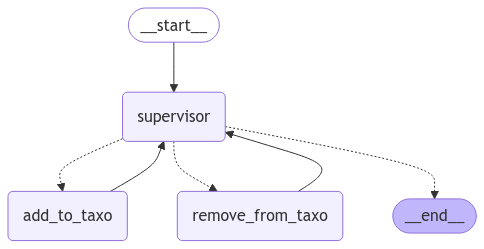

In [13]:
from IPython.display import Image, display

display(Image(taxo_modifier_graph.get_graph().draw_mermaid_png()))

In [126]:
for s in taxo_modifier_graph.stream(
    {
        "messages": [
            (
                "user",
                "Can you add a concept Entreprise to the D4W taxonomy (namespace: http://publications.europa.eu/ontology/authority/). Propose labels and definitions.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'add_to_taxo'}}
---
{'messages': [HumanMessage(content='Can you add a concept Entreprise to the D4W taxonomy (namespace: http://publications.europa.eu/ontology/authority/). Propose labels and definitions.', additional_kwargs={}, response_metadata={}, id='12dda2cb-787a-4170-a37b-b2db9917ac4e')], 'next': 'add_to_taxo'}
http://publications.europa.eu/ontology/authority/Entreprise
Entreprise
{'add_to_taxo': {'messages': [HumanMessage(content='The concept "Entreprise" has been successfully added to the D4W taxonomy with the proposed labels and definitions.', additional_kwargs={}, response_metadata={}, name='add_to_taxo', id='573755f8-4d1c-4b88-9285-3b198a91fbc4')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [21]:
system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. The workers specialize in different tasks:"
        "\n- `research_team`: Looks for information in a search index and on the web."
        "\n- `writing_team`: Modify the taxonomy of the user."
        "\n- `FINISH`: Concludes the process if sufficient information is available to"
        " address the user's query."
        "\n\nYour task is to analyze the user's request and decide the next worker to call."
        "\n- If the user explicitly asks to search something, route to `research_team`."
        "\n- If the user explicitly asks to remove, remove, or modify concepts from the taxonomy, route to `writing_team`."
        "\n- If the first worker did not provide sufficient information, route to the other one."
        "\n- If the user's request is fully addressed, route to `FINISH`."
        "\n\nAlways respond with the name of the next worker to act. Do not perform any"
        " tasks yourself. Never route twice to the same worker"
                    )

In [22]:
from langchain_core.messages import BaseMessage

llm = AzureChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"], system_prompt)

def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = taxo_modifier_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }


# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

# Define the control flow
super_builder.add_edge(START, "supervisor")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor", lambda state: state["next"])
super_graph = super_builder.compile()

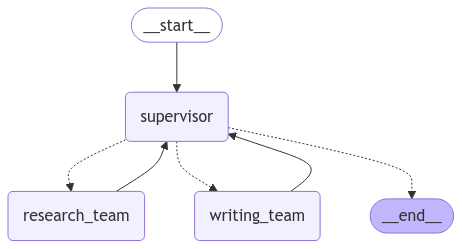

In [16]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [23]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Peux-tu m'aider à modifier ma taxonomie?")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'writing_team'}}
---
{'writing_team': {'messages': [HumanMessage(content="Merci de me fournir les informations suivantes pour que je puisse supprimer le concept de ta taxonomie :\n\n1. Le nom de la taxonomie à modifier.\n2. Le namespace de ta taxonomie.\n3. Le concept que tu souhaites supprimer.\n\nUne fois que j'aurai ces informations, je pourrai procéder à la modification.", additional_kwargs={}, response_metadata={}, name='writing_team', id='0af16d87-09a7-43d6-9073-c6c675d6e9d7')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [91]:
from rdflib import Graph, Namespace  
from rdflib.namespace import SKOS, RDF  
  
# Load the Turtle file  
g = Graph()  
g.parse(r"C:\Users\ecaudron001\Documents\GitHub\AdN\chatbot\RAG\output.ttl", format="ttl")  
  
# Define SKOS namespace  
skos = Namespace(SKOS)  
  
# Extract concepts and broader/narrower relationships  
concepts = set(g.subjects(RDF.type, skos.Concept))  
relations = set(g.triples((None, skos.broader, None)))  
  
# Create a dictionary to hold the hierarchy  
taxonomy = {concept: [] for concept in concepts}  
  
for narrower, _, broader in relations:  
    if broader in taxonomy: 
        print(broader) 
        taxonomy[broader].append(narrower)

http://example.org/resource


In [73]:
schemes = set(g.triples((None, skos.inScheme, None)))  
for concept, _, scheme in schemes:
    concept_scheme = scheme
    taxonomy[concept_scheme] = []
    break

In [74]:
for concept in taxonomy.keys():

    if not taxonomy[concept]:
        taxonomy[concept_scheme].append(concept)

In [88]:
def generate_mermaid(taxonomy):  
    lines = ["graph TD"]  
    for broader, narrowers in taxonomy.items():  
        for narrower in narrowers:  
            lines.append(f"  {broader.n3()} <|-- {narrower.n3()}")  
    return "\n".join(lines)  
  
mermaid_syntax = generate_mermaid(taxonomy)  

In [89]:
from IPython.display import display, HTML

# HTML template with Mermaid
html_template = f"""
<div class="mermaid">
{mermaid_syntax}
</div>
<script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js"></script>
<script>
mermaid.initialize({{ startOnLoad: true }});
</script>
"""

# Display in Jupyter
display(HTML(html_template))